In [26]:
%load_ext autoreload
%autoreload 2


import os
import sys
from pathlib import Path
import bainite_boundaries
project_root = os.path.abspath(Path(str(bainite_boundaries.PROJECT_ROOT), 'bainite_boundaries', 'bainite_boundaries'))

# Add `bainite_boundaries` to sys.path if it’s not already present
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
import numpy as np
import pandas as pd
from collections import Counter

import torch
import gpytorch
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from bainite_boundaries.utils.data_processing import stable_log10


import numpy as np
import pandas as pd

def plot_and_compute_mean_over_cp_cv_folds(results: pd.DataFrame, column = 'y_test', title = ''):
    # Dictionary to store the mean y_test values for each CV fold
    total_results = []

    # Loop over each CV fold
    for index in results['CV_fold'].unique():
        fold_data = results[results['CV_fold'] == index]
        
        # List to store the y_test values for each CP_CV_fold within the current CV fold
        cp_mean_values = []
        
        # Loop over each CP_CV_fold for the current CV fold
        for cp_fold in fold_data['CP_CV_fold'].unique():
            cp_fold_data = fold_data[fold_data['CP_CV_fold'] == cp_fold]
            
            # Extract the y_test and convert it to a numpy array

            string = cp_fold_data[column].iloc[0]  # Assuming the y_test for the same CP_CV_fold is the same
            # if it is a string
            if isinstance(string, str):
                string = string.replace('\n', ' ').strip('[]')
                y_test_array = np.fromstring(string, dtype=float, sep=' ')
            else:
                y_test_array = string
            
            # Append the mean of y_test_array for this CP_CV_fold
            cp_mean_values.append(y_test_array)
            
            # print( f" CV_fold: {index}, CP_CV_fold: {cp_fold}, y_test: {y_test_array}")
        
        # Calculate the mean over all CP_CV_folds for the current CV fold
        total_results.append(np.mean(cp_mean_values, axis=0))
        
    
    
    # Return the results
    return total_results


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data


In [27]:
which_data = 'Austensite'
which_data = 'Martensite_start'
which_data = 'Martensite_start_RA'
which_data = 'Bainite'
#which_data = 'Ferrite'
#which_data = 'Ferrite_critCR'
#which_data = 'Bainite_start'
#'RF', 'XGB_no_monotonic', 'LGBM_no_monotonic'
# 'linear','linear_mixed','polynomial','polynomial_mixed', 'neural', 'GP'
model = {
    'Austensite': 'Austenite',
    'Martensite_start': 'GP_linearmean', 
    'Martensite_start_RA': 'GP_linearmean', 
    'Bainite_start': 'GP_linearmean',
    'Bainite': 'linear',
    'Ferrite': 'GP_Poly',
    'Ferrite_critCR': 'RF',
}[which_data]

axis_label = {
    'Martensite_start': [r'$M_{S,true}$ / $C^{\circ}$', '$M_{S,pred}$ / $C^{\circ}$', '$M_{S,true}$', '$M_{S}$'],
    'Martensite_start_RA': [r'$M_{S,RA,true}$ / $C^{\circ}$', '$M_{S,RA,pred}$ / $C^{\circ}$', '$M_{S,RA,true}$', '$M_{S,RA}$'],
    'Bainite_start': [r'$B_{S,true}$ / $C^{\circ}$', '$B_{S,pred}$ / $C^{\circ}$', '$B_{S,true}$', '$B_{S}$'],
    'Bainite': [r'$B_{t90,true}$ / $C^{\circ}$', '$B_{t90,pred}$ / $C^{\circ}$', '$B_{t90,true}$', '$B_{t90}$'],
    'Ferrite': [r'$F_{t5,true}$ / $C^{\circ}$', '$F_{t5,pred}$ / $C^{\circ}$', '$F_{t5,true}$', '$F_{t5}$'],
    'Ferrite_critCR': [r'$\dot{T}_{\text{crit,true}}$ / $^{\circ}C/s$', r'$\dot{T}_{\text{crit,pred}}$ / $^{\circ}C/s$', r'$\dot{T}_{\text{crit,true}}$', r'$\dot{T}_{\text{crit}}$'],
}[which_data] 
    


filename = f'./bainite_boundaries/results/k-fold-CV/{which_data}_{model}_results'
results = pd.read_csv(filename+'.csv')
# load pickle
# results = pd.read_pickle(filename+'.pkl')
# results.head()

if which_data == 'Austensite':
    classification = True
else:
    classification = False

<>:21: SyntaxWarning: invalid escape sequence '\c'
<>:22: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
<>:21: SyntaxWarning: invalid escape sequence '\c'
<>:22: SyntaxWarning: invalid escape sequence '\c'
<>:23: SyntaxWarning: invalid escape sequence '\c'
<>:24: SyntaxWarning: invalid escape sequence '\c'
<>:25: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1036108/3629749272.py:21: SyntaxWarning: invalid escape sequence '\c'
  'Martensite_start': [r'$M_{S,true}$ / $C^{\circ}$', '$M_{S,pred}$ / $C^{\circ}$', '$M_{S,true}$', '$M_{S}$'],
/tmp/ipykernel_1036108/3629749272.py:22: SyntaxWarning: invalid escape sequence '\c'
  'Martensite_start_RA': [r'$M_{S,RA,true}$ / $C^{\circ}$', '$M_{S,RA,pred}$ / $C^{\circ}$', '$M_{S,RA,true}$', '$M_{S,RA}$'],
/tmp/ipykernel_1036108/3629749272.py:23: SyntaxWarning: invalid escape sequence '

### Compute metrics


In [28]:
from utils.data_processing import compute_metrics_regression
from utils.data_processing import compute_metrics_classification


if classification:

    # labels and predictions
    y_test = plot_and_compute_mean_over_cp_cv_folds(results, column='y_test', title='y_test')
    y_pred_test_mean = plot_and_compute_mean_over_cp_cv_folds(results, column='y_pred_test', title='y_pred_test_mean')
    y_pred_proba_test_mean = plot_and_compute_mean_over_cp_cv_folds(results, column='y_pred_proba_test', title='y_pred_proba_test_mean')

    confidence_sets = plot_and_compute_mean_over_cp_cv_folds(results, column='confidence_sets_test', title='confidence_sets_test')
    confidence_sets_distance = plot_and_compute_mean_over_cp_cv_folds(results, column='confidence_sets_distance_test', title='confidence_sets_distance_test')
    
    metrics_list = []
    for i in range(len(y_test)):
        prediction_dict = {
            'y_true': y_test[i],
            'y_pred': y_pred_test_mean[i],
            'y_pred_proba': y_pred_proba_test_mean[i],
            'confidence_sets': confidence_sets[i],
            'confidence_sets_distance': confidence_sets_distance[i],
        }

        metrics_dict = compute_metrics_classification(prediction_dict)
        metrics_list.append(metrics_dict)
        
else:    

    # labels and predictions
    y_test = plot_and_compute_mean_over_cp_cv_folds(results, column='y_test', title='y_test')
    y_pred_test_mean = plot_and_compute_mean_over_cp_cv_folds(results, column='y_pred_test', title='y_pred_test_mean')


    # with distance
    y_test_lower_distance = plot_and_compute_mean_over_cp_cv_folds(results, column='lower_CP_distance_test', title='y_test_lower')
    y_test_upper_distance = plot_and_compute_mean_over_cp_cv_folds(results, column='upper_CP_distance_test', title='y_test_upper')

    # no distance
    y_test_lower = plot_and_compute_mean_over_cp_cv_folds(results, column='lower_CP_test', title='y_test_lower')
    y_test_upper = plot_and_compute_mean_over_cp_cv_folds(results, column='upper_CP_test', title='y_test_upper')

    metrics_list = []
    for i in range(len(y_test)):
        prediction_dict = {
            'y_true': y_test[i],
            'y_pred': y_pred_test_mean[i],
            'lower_CP': y_test_lower[i],
            'upper_CP': y_test_upper[i],
            'lower_CP_distance': y_test_lower_distance[i],
            'upper_CP_distance': y_test_upper_distance[i],
        }

        metrics_dict = compute_metrics_regression(prediction_dict)
        metrics_list.append(metrics_dict)
        
# Initialize containers for each metric
metrics_aggregated = {key: [] for key in metrics_list[0].keys()}

# Aggregate the values for each metric
for entry in metrics_list:
    for key, value in entry.items():
        metrics_aggregated[key].append(value)

# Calculate the mean and std for each metric
metrics_summary = {key: {'mean': np.mean(values), 'std': np.std(values)} for key, values in metrics_aggregated.items()}
print(results['distance_metric'][0], results['distance_loc'][0])

# Print the results
for metric, summary in metrics_summary.items():
    print(f"{metric}: $ {summary['mean']:.2f} \pm {summary['std']:.2f} $")


<>:71: SyntaxWarning: invalid escape sequence '\p'
<>:71: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1036108/807144086.py:71: SyntaxWarning: invalid escape sequence '\p'
  print(f"{metric}: $ {summary['mean']:.2f} \pm {summary['std']:.2f} $")


mahalanobis PCA_scaled
MALE: $ 0.32 \pm 0.10 $
MAPE [%]: $ 124.88 \pm 101.20 $
MAE: $ 5041.55 \pm 11598.73 $
R2: $ -3.74 \pm 4.99 $
R2log: $ 0.58 \pm 0.50 $
coverage [%]: $ 89.71 \pm 9.13 $
coverage_distance [%]: $ 89.77 \pm 8.89 $
interval_size : $ 9782.79 \pm 6545.66 $
interval_size_distance : $ 9454.81 \pm 5411.70 $
interval_log_size: $ 1.38 \pm 0.10 $
interval_log_size_distance: $ 1.35 \pm 0.07 $


### Plotting

In [29]:
y_test = np.hstack(y_test)
y_pred_test_mean = np.hstack(y_pred_test_mean)
y_test_lower_distance = np.hstack(y_test_lower_distance)
y_test_upper_distance = np.hstack(y_test_upper_distance)
y_test_lower = np.hstack(y_test_lower)
y_test_upper = np.hstack(y_test_upper)

if which_data in ['Martensite_start', 'Bainite_start', 'Bainite', 'Ferrite','Martensite_start_RA','Ferrite_critCR']:
    print('Log transforming data')
    # Transform values to log domain
    y_test = np.log(y_test)
    y_pred_test_mean = np.log(y_pred_test_mean)
    y_test_lower = np.log(y_test_lower)
    y_test_upper = np.log(y_test_upper)
    y_test_lower_distance = np.log(y_test_lower_distance)
    y_test_upper_distance = np.log(y_test_upper_distance)

# difference 
uncertainty = (y_test_upper - y_test_lower) /2 
uncertainty_distance = (y_test_upper_distance - y_test_lower_distance) /2

residuals = np.abs( y_test - y_pred_test_mean )
residuals_ratio = residuals / uncertainty
residuals_ratio_distance = residuals / uncertainty_distance

coverage = np.sum( (y_test_lower <= y_test) & (y_test <= y_test_upper) ) / len(y_test)
print(f"Coverage: {coverage}")

coverage_symmetric = 1- np.sum( residuals_ratio > 1 ) / len(residuals_ratio)
print(f"Coverage symmetric: {coverage_symmetric}")

coverage_distance = np.sum( (y_test_lower_distance <= y_test) & (y_test <= y_test_upper_distance) ) / len(y_test)
print(f"Coverage distance: {coverage_distance}")


Log transforming data
Coverage: 0.8961538461538462
Coverage symmetric: 0.9
Coverage distance: 0.8961538461538462


<>:89: SyntaxWarning: invalid escape sequence '\D'
<>:89: SyntaxWarning: invalid escape sequence '\m'
<>:89: SyntaxWarning: invalid escape sequence '\%'
<>:89: SyntaxWarning: invalid escape sequence '\D'
<>:89: SyntaxWarning: invalid escape sequence '\m'
<>:89: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_1036108/1236397758.py:89: SyntaxWarning: invalid escape sequence '\D'
  inset_ax.set_xlabel(f'$2 | \Delta${axis_label[3]}$ | ~ / ~ |\mathcal{{C}}_{{90\%}}|$', fontsize=12, labelpad=0)
/tmp/ipykernel_1036108/1236397758.py:89: SyntaxWarning: invalid escape sequence '\m'
  inset_ax.set_xlabel(f'$2 | \Delta${axis_label[3]}$ | ~ / ~ |\mathcal{{C}}_{{90\%}}|$', fontsize=12, labelpad=0)
/tmp/ipykernel_1036108/1236397758.py:89: SyntaxWarning: invalid escape sequence '\%'
  inset_ax.set_xlabel(f'$2 | \Delta${axis_label[3]}$ | ~ / ~ |\mathcal{{C}}_{{90\%}}|$', fontsize=12, labelpad=0)
/tmp/ipykernel_1036108/1236397758.py:103: UserWarning: This figure includes Axes that are not com

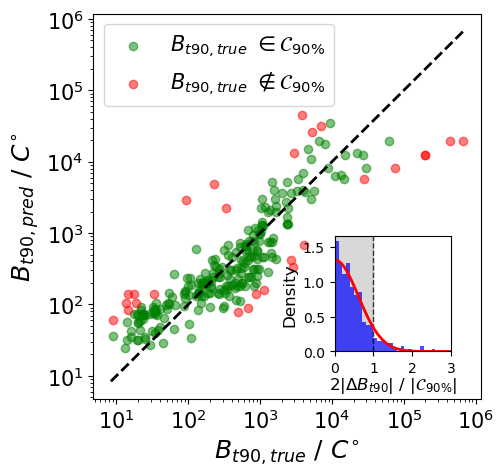

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Set global font size and styles for publication-quality plots
plt.rcParams.update({
    'font.size': 15,            # Smaller font size for LaTeX papers
    'axes.titlesize': 18,      # Title font size
    'axes.labelsize': 18,       # Axis label font size
    'xtick.labelsize': 15,      # Tick label font size
    'ytick.labelsize': 15,      # Tick label font size
    'legend.fontsize': 15,      # Legend font size
    'lines.linewidth': 2,      # Thinner lines for compact figures
    'figure.figsize': (5, 5),  # Adjust figure size for 1/2 page width (LaTeX typical width: 7 inches)
})

distance = True


fig, ax = plt.subplots(figsize=(5, 5))

if which_data in ['Martensite_start','Martensite_start_RA', 'Bainite_start', 'Bainite', 'Ferrite','Ferrite_critCR']:

    # Transform the predicted values
    y_pred_test_mean_transformed = np.exp(y_pred_test_mean)
    y_test_transformed =np.exp(y_test)
    # Main plot: Actual vs Predicted
    # ax.scatter(y_test_transformed, y_pred_test_mean_transformed, alpha=0.5, label='Test set')
    # check if y_test is between y_test_lower and y_test_upper
    if distance:
        within_uncertainty_interval = (y_test >= y_test_lower_distance) & (y_test <= y_test_upper_distance)
    else:
        within_uncertainty_interval = (y_test >= y_test_lower) & (y_test <= y_test_upper)
        
    # Color points based on whether they are within or outside the uncertainty interval
    ax.scatter(y_test_transformed[within_uncertainty_interval], y_pred_test_mean_transformed[within_uncertainty_interval], alpha=0.5, label=f'{axis_label[2]} $\\in \\mathcal{{C}}_{{90\\%}}$', color='g')
    ax.scatter(y_test_transformed[~within_uncertainty_interval], y_pred_test_mean_transformed[~within_uncertainty_interval], alpha=0.5, label=f'{axis_label[2]} $\\notin \\mathcal{{C}}_{{90\\%}}$', color='r')
    x = np.linspace(np.min(y_test_transformed)*.95, np.max(y_test_transformed), 100)
    ax.plot(x, x, color='k', linestyle='--')


    if which_data in ['Bainite', 'Ferrite','Ferrite_critCR']:
        # # Define tick range based on the data and step size
        # min_tick = np.floor(np.min(y_test_transformed) / 50) * 50
        # max_tick = np.ceil(np.max(y_test_transformed) / 50) * 50
        # ticks = np.arange(min_tick, max_tick + 1, 100)  # Step size is 50


        # Set logarithmic scale
        ax.set_xscale('log')
        ax.set_yscale('log')

        # # Set ticks and tick labels
        # ax.set_xticks(ticks)
        # ax.set_yticks(ticks)
        # tick_labels = [f"{int(tick)}" for tick in ticks]
        # ax.set_xticklabels(tick_labels)
        # ax.set_yticklabels(tick_labels)
    
else:
    
    ax.scatter(y_test, y_pred_test_mean, alpha=0.5, label='Test set')
    x = np.linspace(np.min(y_test), np.max(y_test), 100)
    ax.plot(x, x, color='k', linestyle='--', label='y = x')
# Set axis labels
ax.set_xlabel(axis_label[0])
ax.set_ylabel(axis_label[1])
ax.legend(loc='upper left')

# Inset plot: Histogram of residuals
inset_ax = inset_axes(ax, width="30%", height="30%", bbox_to_anchor=(-0.05, -0.55, 1, 1), bbox_transform=ax.transAxes)
inset_ax.axvspan(
    0, 1, 
    color='gray', 
    alpha=0.3
)
# dashed vertical line
inset_ax.axvline(1, color='k', linestyle='--', lw=1, alpha=0.75, 
    label=f'{coverage_symmetric*100:.1f}% quantile')

# Plot histogram of residuals_ratio

residuals_ratio = residuals / uncertainty
inset_ax.hist(residuals_ratio, bins=30, alpha=0.7, color='b', density=True,range=(0,3))

# Set inset title and legend
# inset_ax.set_xlabel('Residuals/Uncertainty', fontsize=10)

inset_ax.set_xlabel(f'$2 | \Delta${axis_label[3]}$ | ~ / ~ |\mathcal{{C}}_{{90\%}}|$', fontsize=12, labelpad=0)

inset_ax.set_ylabel('Density', fontsize=12)
# size of x and y ticks
inset_ax.tick_params(axis='both', which='major', labelsize=10)
# inset_ax.legend(fontsize=10, bbox_to_anchor=(0.5, 1.3), loc='upper center')

# xtick at 0, 1, 2
inset_ax.set_xticks(np.arange(0, 10.1, 1))
inset_ax.set_xlim(0, 3)

xx=np.linspace(0,3,100)
inset_ax.plot(xx,1/np.sqrt(2*3.1415*1/1.645**2)*np.exp(-xx**2*1.645**2/2)*2,color='red')

plt.tight_layout(pad=30.0)

plt.show()

# save figure
fig.savefig(f'./bainite_boundaries/plots/pred-vs-actual/{which_data}_{model}_results.png', bbox_inches='tight', dpi=300)
